# GRUAN

The `GRUAN` data interface was added to pycontrails v0.59.0. It allows users to download and cache radiosonde data from the [GRUAN network](https://www.gruan.org/). The GRUAN network provides high-quality radiosonde measurements (including uncertainties), making it useful for evaluating weather models and contrail prediction tools.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm

from pycontrails import JetA
from pycontrails.datalib.gruan import GRUAN
from pycontrails.models import pcr
from pycontrails.physics import constants, thermo, units

In [2]:
# Use the AVAILABLE attribute to see available products and sites
GRUAN.AVAILABLE

{'RS-11G-GDP.1': ['SYO', 'TAT', 'NYA', 'LIN'],
 'RS41-EDT.1': ['LIN', 'POT', 'SNG'],
 'RS92-GDP.1': ['BOU', 'CAB', 'LIN', 'PAY', 'POT', 'SOD', 'TAT'],
 'RS92-GDP.2': ['BAR',
  'BEL',
  'BOU',
  'CAB',
  'DAR',
  'GRA',
  'LAU',
  'LIN',
  'MAN',
  'NAU',
  'NYA',
  'PAY',
  'POT',
  'REU',
  'SGP',
  'SOD',
  'TAT',
  'TEN',
  'GVN'],
 'RS92-PROFILE-BETA.2': ['BOU', 'CAB', 'LIN', 'POT', 'SOD', 'TAT'],
 'RS92-PROFILE-BETA.3': ['BOU', 'CAB', 'LIN', 'POT', 'SOD', 'TAT']}

In [3]:
# We instantiate using the RS92-GDP.2 product at the LIN (Lindenberg) site
gruan = GRUAN("RS92-GDP.2", "LIN")

# Check which years have data in this product/site
gruan.years()

[2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2020,
 2021]

In [4]:
# See the available files in 2016
# Use the extract_gruan_time function to get datetime info from filenames (not shown here)
gruan.list_files(2016)[:10]

['LIN-RS-01_2_RS92-GDP_002_20160108T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T060000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T060000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T120000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T120000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160108T180000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160101T180000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160109T000000_1-000-001.nc',
 'LIN-RS-01_2_RS92-GDP_002_20160102T000000_1-000-001.nc']

## Single sounding

We pull a single sounding from the Lindenberg site and visualize some of the data over its trajectory.

In [5]:
# Choose a single file (this one taken from the above list) and download it
file = "LIN-RS-01_2_RS92-GDP_002_20160102T120000_1-000-001.nc"
ds = gruan.get(file)  # automatically cached

# Check that our assumptions about units are correct
# Other sites or products may have different conventions
assert ds["press"].attrs["units"] == "hPa"
assert ds["temp"].attrs["units"] == "K"
assert ds["rh"].attrs["units"] == "1"

ds

<xarray.Dataset> Size: 770kB
Dimensions:     (time: 6209)
Coordinates:
  * time        (time) datetime64[ns] 50kB 2016-01-02T10:48:34 ... 2016-01-02...
    lon         (time) float32 25kB ...
    lat         (time) float32 25kB ...
    alt         (time) float32 25kB ...
Data variables: (12/26)
    press       (time) float32 25kB ...
    temp        (time) float32 25kB ...
    rh          (time) float32 25kB ...
    wdir        (time) float32 25kB ...
    wspeed      (time) float32 25kB ...
    geopot      (time) float32 25kB ...
    ...          ...
    u_std_rh    (time) float32 25kB ...
    cor_rh      (time) float32 25kB ...
    u_cor_rh    (time) float32 25kB ...
    u_rh        (time) float32 25kB ...
    u_wdir      (time) float32 25kB ...
    u_wspeed    (time) float32 25kB ...
Attributes: (12/60)
    Conventions:                        CF-1.4
    title:                              RS92 GRUAN Data Product (Version 2)
    institution:                        MOL - Lindenberg Meteorological Obser...
    source:                             RS92-SGP
    history:                            2016-01-02 14:09:48.000Z RS92-GDP: RS...
    references:                         Currently no references
    ...                                 ...
    g.Instrument.TypeFamily:            RS92
    g.Instrument.Manufacturer:          Vaisala
    g.Instrument.Weight:                160.0 g
    g.Instrument.TelemetrySonde:        RS92
    g.Instrument.SoftwareVersion:       3.66.1
    g.Instrument.Comment:               VP_formula: HylandWexler,

In [6]:
# Compute RHi from RH and T
T = ds["temp"]
e_sw = thermo.e_sat_liquid(T)
e_si = thermo.e_sat_ice(T)
rhi = ds["rh"] * e_sw / e_si

# Compute barometric altitude (altitude used in aviation) from pressure
alt_ft = units.pl_to_ft(ds["press"])

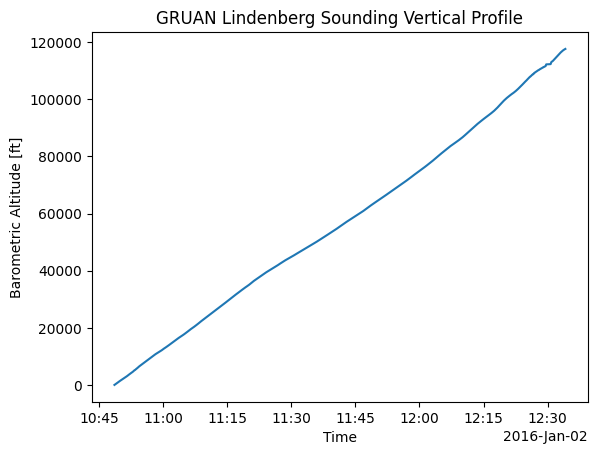

In [7]:
alt_ft.plot()
plt.xlabel("Time")
plt.ylabel("Barometric Altitude [ft]")
plt.title("GRUAN Lindenberg Sounding Vertical Profile")
plt.show()

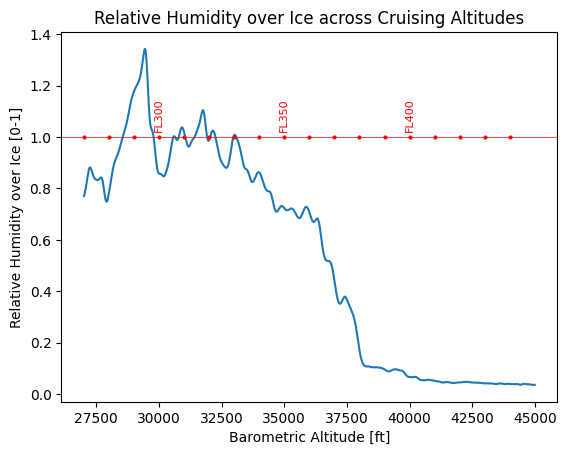

In [8]:
cond = (alt_ft >= 27000.0) & (alt_ft <= 45000.0)

plt.plot(alt_ft[cond], rhi[cond])
plt.xlabel("Barometric Altitude [ft]")
plt.ylabel("Relative Humidity over Ice [0-1]")
plt.title("Relative Humidity over Ice across Cruising Altitudes")
plt.axhline(1.0, color="red", label="RHi = 1", linewidth=0.5)
for FL in range(27000, 45000, 1000):
    plt.plot(FL, 1.0, "ro", markersize=2)
    if FL % 5000 == 0:
        plt.text(FL, 1.03, f"FL{FL // 100}", color="red", fontsize=8, ha="center", rotation=90)

plt.show()

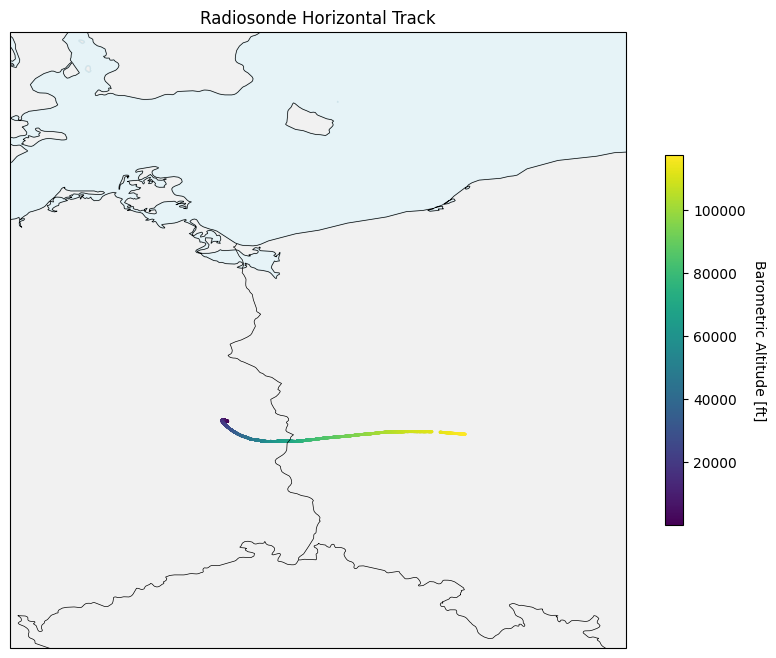

In [9]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree(), extent=[12, 18, 50, 56])

ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)
ax.add_feature(cfeature.LAND, alpha=0.3, color="lightgray")
ax.add_feature(cfeature.OCEAN, alpha=0.3, color="lightblue")

scatter = ax.scatter(ds["lon"], ds["lat"], c=alt_ft, s=1)
cbar = plt.colorbar(scatter, ax=ax, shrink=0.6)
cbar.set_label("Barometric Altitude [ft]", rotation=270, labelpad=15)

plt.title("Radiosonde Horizontal Track")
plt.show()

## Sounding Statistics

We can look at all soundings in 2016 and compute some interesting statistics:

- Persistent Contrail Region (PCR := ISSR & SAC) likelihood at each Flight Level (FL)
- Depth of thickest PCR layer per sounding (as a simple measure of contrail avoidance difficulty)

This isn't meant to be comprehensive analysis, just a demonstration of possible uses of the GRUAN data for contrail studies.

In [10]:
FLs = np.arange(27000, 44000 + 1, 1000)  # FL270 to FL440
ETA = 0.3  # Fix a constant value for engine efficiency


def pcr_at_FLs(ds: xr.Dataset) -> np.ndarray:
    """Compute PCR at specified FLs by interpolating from the GRUAN profile."""
    assert ds["press"].attrs["units"] == "hPa"
    assert ds["temp"].attrs["units"] == "K"
    assert ds["rh"].attrs["units"] == "1"

    pl = ds["press"]
    alt_ft = units.pl_to_ft(pl)
    T = ds["temp"]
    rh = ds["rh"]

    # We can interpolate before or after converting from RH to q
    # We choose to interpolate before. With dense profiles (like GRUAN), either way works fine.
    interped_T = np.interp(FLs, alt_ft, T)
    interped_rh = np.interp(FLs, alt_ft, rh)
    interped_p = units.ft_to_pl(FLs) * 100.0  # hPa -> Pa
    interped_q = interped_rh * constants.epsilon * thermo.e_sat_liquid(interped_T) / interped_p

    return pcr.pcr(interped_T, interped_q, interped_p, ETA, ei_h2o=JetA.ei_h2o, q_fuel=JetA.q_fuel)[
        0
    ]


def thickest_depth(arr: np.ndarray) -> int:
    """Compute the thickest continuous depth given a boolean array."""
    if not np.any(arr):
        return 0

    edges = np.diff(np.r_[False, arr, False].astype(int))
    start = np.flatnonzero(edges == 1)
    end = np.flatnonzero(edges == -1)
    return np.max(end - start).item()

In [11]:
files = gruan.list_files(2016)
files.sort()

depths = {}
pcrs = {}
for file in tqdm(files):
    ds = gruan.get(file)
    pcr_ = pcr_at_FLs(ds) == 1.0

    depth = thickest_depth(pcr_)
    t = ds.attrs["g.Ascent.StandardTime"]

    depths[t] = depth
    pcrs[t] = pcr_


depths_ser = pd.Series(depths)
pcr_df = pd.DataFrame.from_dict(pcrs, orient="index", columns=[f"FL{FL // 100}" for FL in FLs])

100%|██████████| 1201/1201 [00:13<00:00, 86.57it/s] 


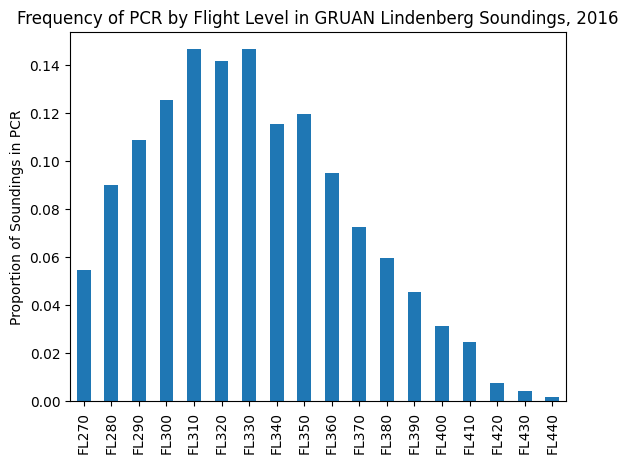

In [12]:
pcr_df.mean(axis=0).plot(kind="bar")
plt.ylabel("Proportion of Soundings in PCR")
plt.title("Frequency of PCR by Flight Level in GRUAN Lindenberg Soundings, 2016")
plt.show()

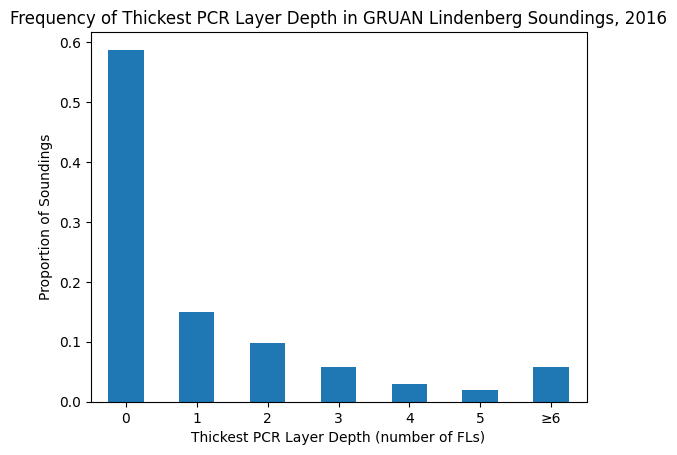

In [13]:
depths_capped = depths_ser.where(depths_ser < 6, 6)

counts = depths_capped.value_counts().sort_index()
proportions = counts / counts.sum()

ax = proportions.plot(kind="bar")
ax.set_xlabel("Thickest PCR Layer Depth (number of FLs)")
ax.set_ylabel("Proportion of Soundings")
ax.set_title("Frequency of Thickest PCR Layer Depth in GRUAN Lindenberg Soundings, 2016")
xticklabels = [*range(6), "≥6"]
ax.set_xticklabels(xticklabels, rotation=0)
plt.show()

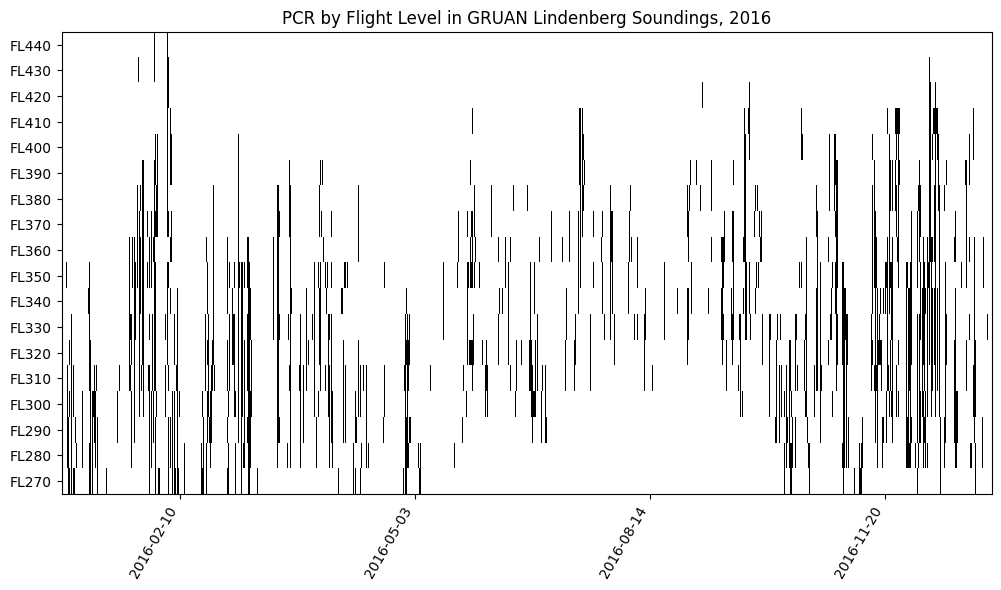

In [14]:
# There are some gaps in the time series which the plot below obfuscates, but
# they are small and infrequent.
plt.figure(figsize=(12, 6))
plt.imshow(pcr_df.T[::-1], aspect="auto", cmap="Grays", interpolation="none")
plt.yticks(ticks=np.arange(len(FLs)), labels=[f"FL{FL // 100}" for FL in FLs[::-1]])
xticks = [150, 450, 750, 1050]
plt.xticks(ticks=xticks, labels=[pcr_df.index[i][:10] for i in xticks], rotation=60, ha="right")
plt.title("PCR by Flight Level in GRUAN Lindenberg Soundings, 2016")
plt.show()